

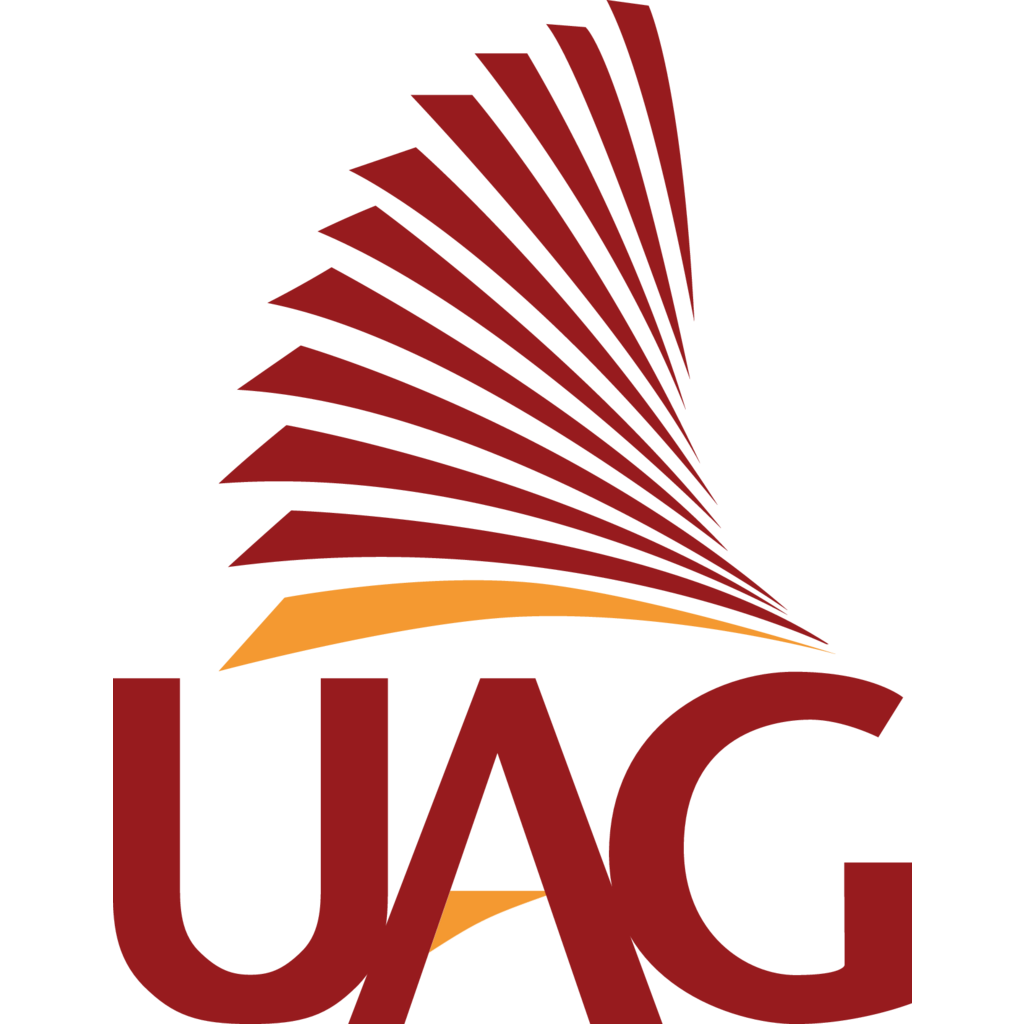

Aprendizaje Automático para la Gestión de Datos Masivos

Dr. Paulo López Meyer

# **Series de tiempo   ***

Itzel Rubi Alcala Gil

2930147




Vamos a comenzar generando una base de datos de ventas del 2018 por 60 meses y cargandolas a nuestro dataframe

In [2]:
import pandas as pd
import numpy as np

# Generar datos de fechas mensuales durante los últimos 5 años
dates = pd.date_range(start='2018-01-01', periods=60, freq='M')

# Generar datos ficticios de ventas mensuales
np.random.seed(0)
sales = np.random.randint(100, 500, size=(60,))

# Crear un DataFrame con los datos
data = pd.DataFrame({'fecha': dates, 'ventas': sales})

# Guardar los datos en un archivo CSV
data.to_csv('ventas_mensuales.csv', index=False)


Ahora vamos a cargar nuestra base de datos y graficarlos para ver como están distribuídos

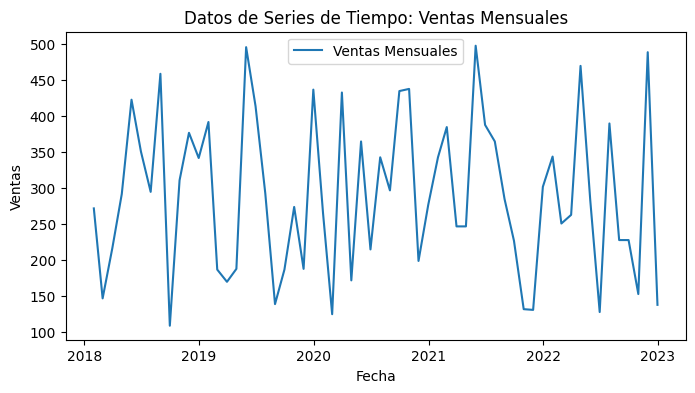

In [25]:
import matplotlib.pyplot as plt

# Cargar datos de ejemplo
data = pd.read_csv('ventas_mensuales.csv', parse_dates=['fecha'], index_col='fecha')
series = data['ventas']

# Plotear los datos
plt.figure(figsize=(8, 4))
plt.plot(series, label='Ventas Mensuales')
plt.title('Datos de Series de Tiempo: Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

Podemos ver que nuestras ventas van de 100 a 500 unidades desde los últimos años.
Ahora vamos a trabjar la información para obtener la tendencia, la estacionalidad y el residual y lo vamos a graficar

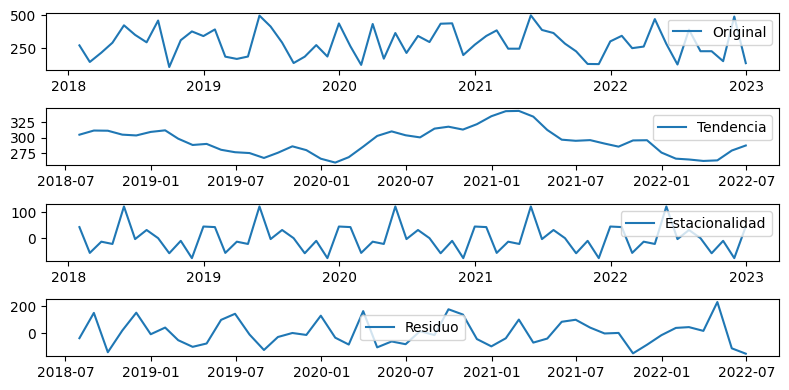

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie de tiempo
decomposition = seasonal_decompose(series, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotear los componentes
plt.figure(figsize=(8, 4))
plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Podemos ver que si rompemos nuestra base de datos en algunos periodos tenemos tendencias a la baja, otros a la alta pero overall, la tendencia no tiene un crecimiento en los 5 años.
Sin embargo, tiene una estacionalidad muy marcada.

## **ARIMA**

A continuación vamos a trabajar un modelo de ARIMA con esta misma base de datos que creamos.
Vamos a graficar nuestra base de datos original y después vamos a calcular la prueba de Dickey-Fuller aumentada para ver si nuestra serie es estacionaria o no.
La prueba de Dicky Fuller ayuda a identificar si los valores de la serie temporal dependen de una tendencia o si son estacionarios, es decir, si sus propiedades estadísticas (como la media y la varianza) son constantes a lo largo del tiempo. Para constuir un ARIMA se requiere que nuestra serie sea estacionaria.

Hipótesis:
Hipótesis nula (H₀): La serie temporal tiene una raíz unitaria (es no estacionaria).
Hipótesis alternativa (H₁): La serie temporal no tiene una raíz unitaria (es estacionaria).


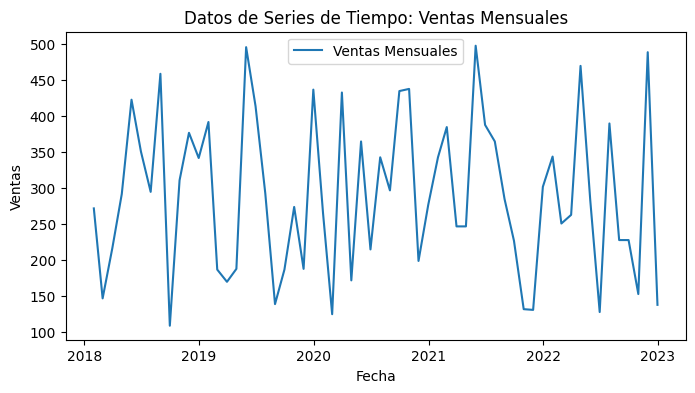

ADF Statistic: -7.929121375083372
p-value: 3.5521636566935744e-12


In [59]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Cargar datos de ejemplo
data = pd.read_csv('ventas_mensuales.csv', parse_dates=['fecha'], index_col='fecha')
series = data['ventas']

# Plotear la serie de tiempo original
plt.figure(figsize=(8, 4))
plt.plot(series, label='Ventas Mensuales')
plt.title('Datos de Series de Tiempo: Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Verificar estacionariedad utilizando la prueba de Dickey-Fuller aumentada
result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Si la serie no es estacionaria, diferenciar los datos
differenced_series = series.diff().dropna()








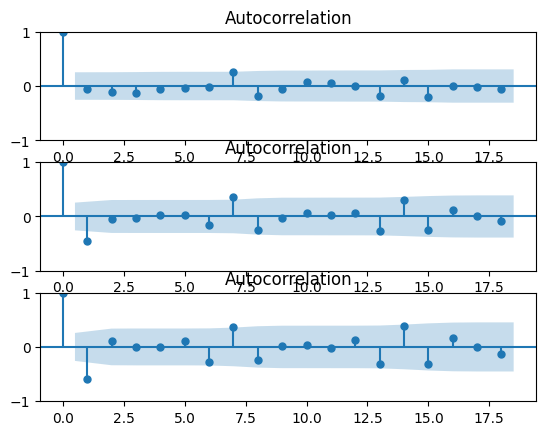

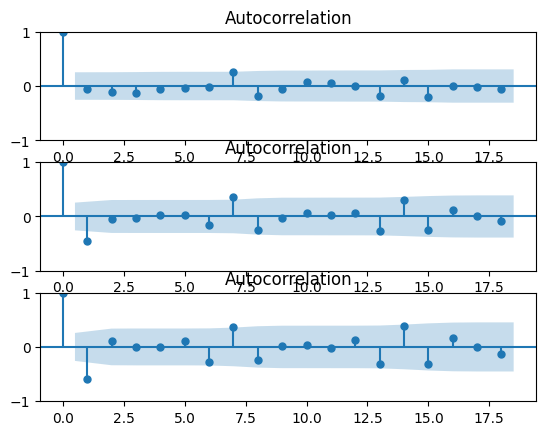

In [61]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(series, ax=ax1)
plot_acf(series.diff().dropna(), ax=ax2)
plot_acf(series.diff().diff().dropna(), ax=ax3)

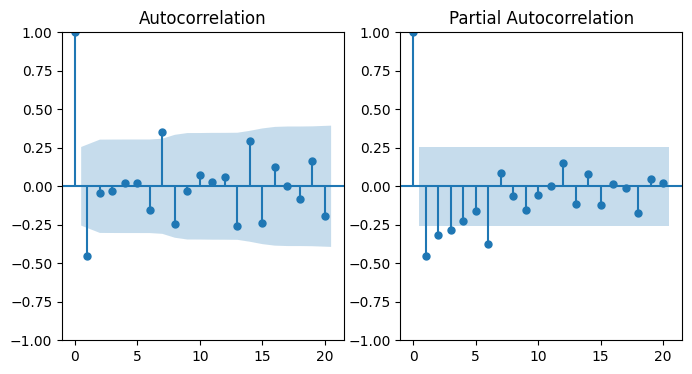

In [28]:
# Identificación de los parámetros p y q utilizando ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sm.graphics.tsa.plot_acf(differenced_series, lags=20, ax=axes[0])
sm.graphics.tsa.plot_pacf(differenced_series, lags=20, ax=axes[1])
plt.show()

Dado que el p-value es extremadamente pequeño y el valor del ADF Statistic es muy negativo, podemos concluir con confianza que:

Rechazamos la hipótesis nula (H₀) de que la serie temporal tiene una raíz unitaria.
Aceptamos la hipótesis alternativa (H₁) de que la serie temporal es estacionaria.
Esto significa que tu serie temporal no presenta una raíz unitaria y es estacionaria, lo cual es una condición favorable para muchos modelos de series temporales, como ARIMA, el cual vamos a construir a continuación.

In [13]:

# Construcción del modelo ARIMA
model = ARIMA(series, order=(7, 1, 2))  # Ajustar p, d, q según los gráficos ACF y PACF
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                   60
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -358.821
Date:                Tue, 16 Jul 2024   AIC                            737.641
Time:                        22:20:00   BIC                            758.416
Sample:                    01-31-2018   HQIC                           745.751
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4297      0.440     -0.976      0.329      -1.293       0.433
ar.L2         -0.1616      0.210     -0.770      0.442      -0.573       0.250
ar.L3         -0.1484      0.217     -0.684      0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


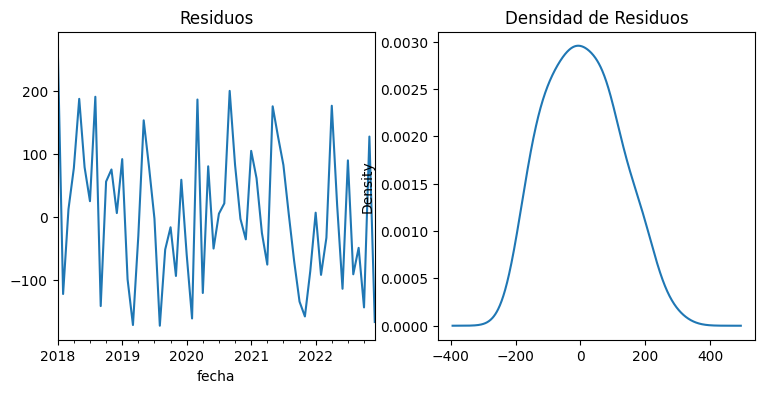

In [31]:
# Diagnóstico de residuos
residuals = model_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
residuals.plot(title="Residuos", ax=axes[0])
residuals.plot(kind='kde', title='Densidad de Residuos', ax=axes[1])
plt.show()

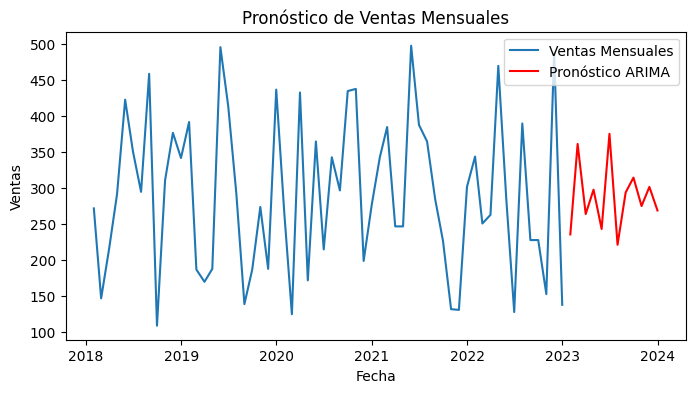

In [32]:
# Pronóstico
forecast_arima = model_fit.forecast(steps=12)
plt.figure(figsize=(8, 4))
plt.plot(series, label='Ventas Mensuales')
plt.plot(forecast_arima, label='Pronóstico ARIMA', color='red')
plt.title('Pronóstico de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

Podemos ver en nuestros gráficos, de color rojo la predicción de nuestro modelo ARIMA.
De  nuestras gráficas de residuos podemos concluír que nuestros residios tienen una distribución aleatoria sin patrones evidentes y la densidad de nuestros residuos parece estar distribuída de manera normal
lo cual sugiere que nuestro modelo fue adecuado.

### **Análisis con prophet**

Ahora vamos a hacer el análisis de la misma base de datos que creamos pero con prophet.

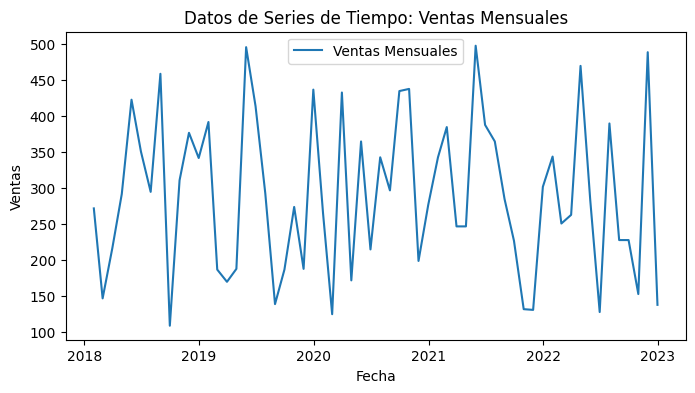

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Cargar datos de ejemplo
data = pd.read_csv('ventas_mensuales.csv', parse_dates=['fecha'], index_col='fecha')
data = data.reset_index()
data.columns = ['ds', 'y']

# Visualizar datos
plt.figure(figsize=(8, 4))
plt.plot(data['ds'], data['y'], label='Ventas Mensuales')
plt.title('Datos de Series de Tiempo: Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx5pmhajo/9dyku476.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx5pmhajo/smtqzofl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20675', 'data', 'file=/tmp/tmpx5pmhajo/9dyku476.json', 'init=/tmp/tmpx5pmhajo/smtqzofl.json', 'output', 'file=/tmp/tmpx5pmhajo/prophet_modeltn52li37/prophet_model-20240716223048.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:30:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:30:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


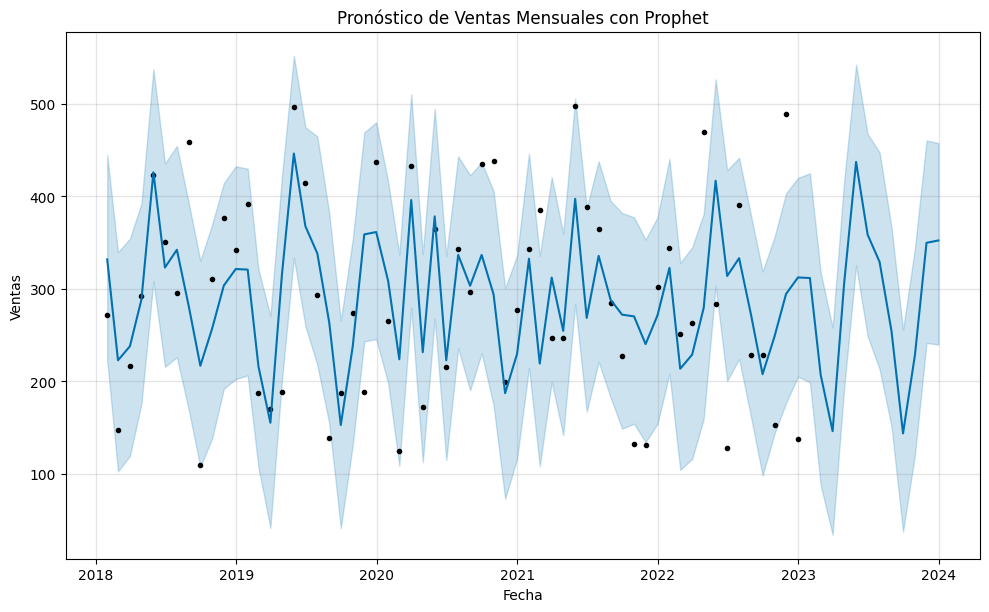

In [45]:
# Construir el modelo Prophet
model = Prophet()
model.fit(data)

# Realizar pronósticos
future = model.make_future_dataframe(periods=12, freq='M')
forecast_prophet = model.predict(future)

# Visualizar pronósticos

fig = model.plot(forecast_prophet)
plt.figsize=(3, 2)
plt.title('Pronóstico de Ventas Mensuales con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()



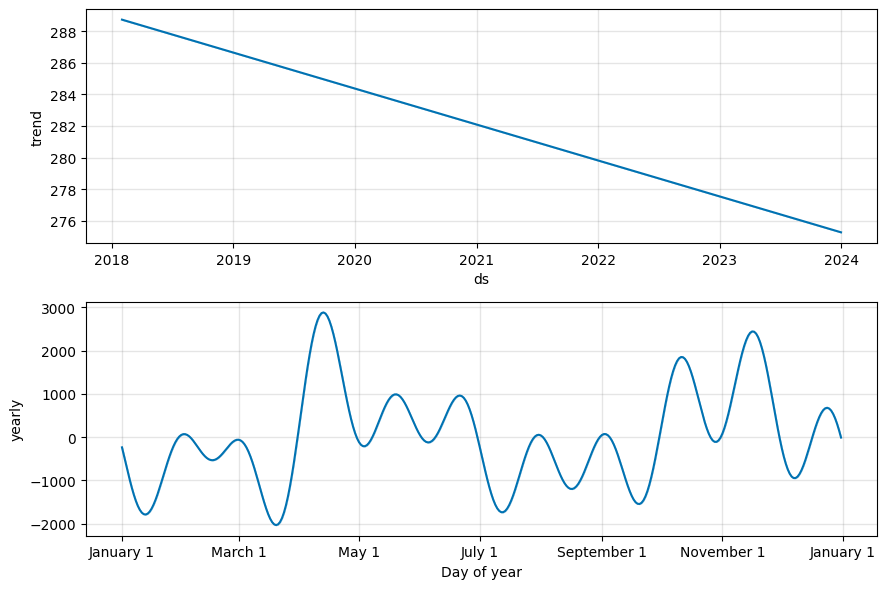

In [47]:

# Visualizar componentes del modelo
fig2 = model.plot_components(forecast_prophet)
plt.show()


De nuestros gráficos podemos observar una predicción de las de 2023 que a simple vista en la grafica, tienen mucho parecido a nuestro histórico ys e comporta mejor que con el modelo ARIMA.

## **LSTM**

Ahora vamos a construír un modelo LSTM (Long Short-Term Memory) (Memoria a Largo Corto Plazo), es un tipo de red neuronal recurrente (RNN) especialmente diseñada para aprender dependencias a largo plazo en datos secuenciales, como las series temporales.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Cargar datos de ejemplo
data = pd.read_csv('ventas_mensuales.csv', parse_dates=['fecha'], index_col='fecha')

# Preprocesamiento de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape data to [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

# Realizar predicciones
train_predict_lstm = model.predict(X_train)
test_predict_lstm = model.predict(X_test)

# Invertir la normalización de los datos
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
y_train = scaler.inverse_transform([y_train])
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
y_test = scaler.inverse_transform([y_test])




Epoch 1/20
46/46 - 5s - loss: 0.2174 - 5s/epoch - 100ms/step
Epoch 2/20
46/46 - 0s - loss: 0.0924 - 134ms/epoch - 3ms/step
Epoch 3/20
46/46 - 0s - loss: 0.0891 - 135ms/epoch - 3ms/step
Epoch 4/20
46/46 - 0s - loss: 0.0837 - 147ms/epoch - 3ms/step
Epoch 5/20
46/46 - 0s - loss: 0.0839 - 154ms/epoch - 3ms/step
Epoch 6/20
46/46 - 0s - loss: 0.0839 - 138ms/epoch - 3ms/step
Epoch 7/20
46/46 - 0s - loss: 0.0836 - 151ms/epoch - 3ms/step
Epoch 8/20
46/46 - 0s - loss: 0.0820 - 144ms/epoch - 3ms/step
Epoch 9/20
46/46 - 0s - loss: 0.0819 - 154ms/epoch - 3ms/step
Epoch 10/20
46/46 - 0s - loss: 0.0810 - 138ms/epoch - 3ms/step
Epoch 11/20
46/46 - 0s - loss: 0.0812 - 156ms/epoch - 3ms/step
Epoch 12/20
46/46 - 0s - loss: 0.0803 - 144ms/epoch - 3ms/step
Epoch 13/20
46/46 - 0s - loss: 0.0800 - 141ms/epoch - 3ms/step
Epoch 14/20
46/46 - 0s - loss: 0.0820 - 159ms/epoch - 3ms/step
Epoch 15/20
46/46 - 0s - loss: 0.0807 - 164ms/epoch - 4ms/step
Epoch 16/20
46/46 - 0s - loss: 0.0802 - 122ms/epoch - 3ms/step
Ep

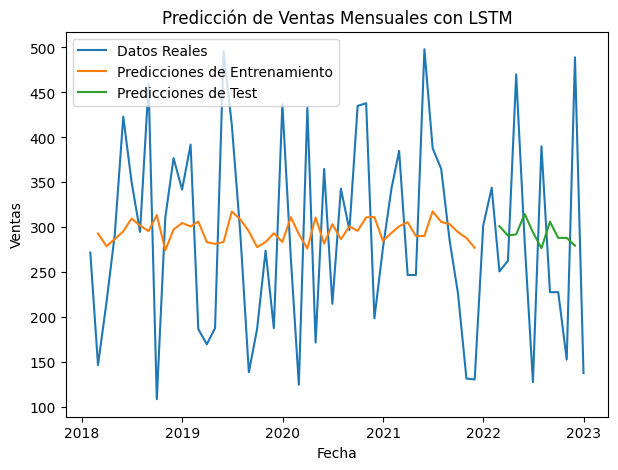

In [56]:
# Visualizar resultados
plt.figure(figsize=(7, 5))
plt.plot(data.index, data.values, label='Datos Reales')
plt.plot(data.index[look_back:len(train_predict_lstm) + look_back], train_predict_lstm, label='Predicciones de Entrenamiento')
plt.plot(data.index[len(train_predict_lstm) + (look_back * 2) + 1:len(data) - 1], test_predict_lstm, label='Predicciones de Test')
plt.title('Predicción de Ventas Mensuales con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

Después de evaluar estos tres modelos, mi conclusión es que para los datos de ventas que tenemos, el mejor modelo es el de prophet ya que las predicciones graficadas muestran un comportamiento más similar a los datos reales.